<a href="https://colab.research.google.com/github/thekhan314/CovidBrazilMod3/blob/master/COVID_REDUX_last_google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Subset Features into floats and categoricals

## Libraries and Functions


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Mod3ProjectCOvid/CovidBrazilMod3')

from khantools import *
import pandas as pd
import numpy as np
import missingno
import pprint as pp
import matplotlib.pyplot as plt
import seaborn as sns
import operator as operator

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/

In [0]:
# Evaluate empty columns
def cols_with_data(dataframe,threshold,plot=False,axis=0):
    ''' returns a series with all columns that are filled to at least threshold percentage or higher'''
    
    counts = dataframe.count(axis=axis).sort_values()
    
    if axis == 0: 
        counts = counts/len(dataframe)
    else:
        counts = counts/len(dataframe.columns)
        
    non_zero_cols = counts[counts >= threshold ]
    
    if plot == True:
        fig,ax = plt.subplots()
        ax.barh(non_zero_cols.index,non_zero_cols)
        fig.set_size_inches(6,9)
        fig.show()
        print("Features left:{}".format(len(non_zero_cols)))
    return non_zero_cols

def value_counts (df,value, oper):
    ''' takes in a datframe of float values, returns count of zero values '''
    dict = {}
    
    ops = {'>': operator.gt,
           '<': operator.lt,
           '>=': operator.ge,
           '<=': operator.le,
           '=': operator.eq}
    
    for col in df.columns:
        matches = sum(ops[oper](df[col],value))
        
        dict[col] = matches
    
    df = pd.Series(dict)
    return df


Lets import the data and run a preliminary report

In [0]:
df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Mod3ProjectCOvid/CovidBrazilMod3/dataset.xlsx')
report_prelim = report1(df,5)

It appears that the most commonly occuring values aside from the ones that are always there is what appears to be a battery of standard tests. I think it might be a good idea to discard all the rows where these tests were not performed, as they are much too sparse to be of any use to us. Lets keep only rows where standard tests were done, and see if that leaves us with enough data to make a meaningful model.

In [6]:
df = df[df['Parainfluenza 2'].notnull()]
report_post_trim = report1(df,6)
print(len(df))
#display(report_post_trim)

1352


# Data Cleanup and sorting

## Rename & Clean Columns

In [0]:
# Lets change the names of some columns to something easier to work with
new_names = {
    'Patient addmited to intensive care unit (1=yes, 0=no)':'intensive',
    'Patient addmited to semi-intensive unit (1=yes, 0=no)':'semi_int',
    'Patient addmited to regular ward (1=yes, 0=no)':'reg_ward',
    'SARS-Cov-2 exam result':'sars_cov2',
    'Patient age quantile':'age_quant',
    'Patient ID':'patient_id'
}

df = df.rename(columns=new_names)
df.set_index(keys='patient_id',inplace=True)

# convert age_quant to float

df['age_quant'] = df['age_quant'].astype(float)
#delete empty columns

empty_cols = list(report_post_trim[report_post_trim['% empty'] == 100.0].index)
df = df.drop(columns=empty_cols)



## Reduce features

In [0]:
# all data: filled values in each column 
col_fill = cols_with_data(df,threshold=0.03)

meaty_cols = list(col_fill[col_fill > 0.1].index)
meaty_cols.append('Lactic Dehydrogenase')

df = df[meaty_cols]

## Subset features

In [0]:
df_types = df.dtypes

float_features = list(df_types[df_types == 'float64'].index)
obj_features = list(df_types[df_types == 'object'].index)

high_imp= ['Lactic Dehydrogenase','Lymphocytes','Proteina C reativa mg/dL']
admission_features = ['intensive','semi_int','reg_ward']



for col in admission_features:
    df[col] = df[col].astype(float)

## Convert Categoricals

In [10]:
report2 = report1(df[obj_features],3).sort_values('unique values')
display(report2)

,type,% empty,unique values,1nth_value,1nth_value_%,2nth_value,2nth_value_%
Parainfluenza 2,object,0.00,1,not_detected,100.00,NaN,NaN
"Influenza B, rapid test",object,80.40,2,negative,18.49,positive,1.11
Rhinovirus/Enterovirus,object,0.00,2,not_detected,71.97,detected,28.03
sars_cov2,object,0.00,2,negative,91.72,positive,8.28
Inf A H1N1 2009,object,0.00,2,not_detected,92.75,detected,7.25
Influenza B,object,0.00,2,not_detected,94.38,detected,5.62
Respiratory Syncytial Virus,object,0.00,2,not_detected,96.15,detected,3.85
CoronavirusNL63,object,0.00,2,not_detected,96.67,detected,3.33
Coronavirus HKU1,object,0.00,2,not_detected,98.52,detected,1.48
"Influenza A, rapid test",object,80.40,2,negative,18.20,positive,1.41


Lets also drop all the unary features because it seems they are all basically negative and dont seem to add much information.

Lets convert the binary categoricals to floats. 

For tests that have a 'not done' value, I will treat 'not done' as negative, since its safe to assume if t he test wasnt done the doctor was expecting a negative anyways. 

Urine Aspect color and crystals I will drop. They dont sound too important, and dont comprise alot of rows.I will also drop standard tests, as I feel they will only add noise.  

Urine PH and Urine Leukocytes should be converted to float



In [11]:
binary_conversions = list(report2[report2['unique values'] == 2].index)

for col in binary_conversions:
    df[col] = df[col].replace(['not_detected','negative','absent','normal'],0)
    df[col] = df[col].replace(['detected','positive','not_done'],1)
    df[col] = df[col].astype(float)

df['sars_cov2'] = df['sars_cov2'].replace(['negative'],0)
df['sars_cov2'] = df['sars_cov2'].replace(['positive'],1)
df.drop('Parainfluenza 2',axis=1,inplace=True)

report3 = report1(df,6)

display(report3)

,type,% empty,unique values,1nth_value,1nth_value_%,2nth_value,2nth_value_%,3nth_value,3nth_value_%,4nth_value,4nth_value_%,5nth_value,5nth_value_%,6nth_value,6nth_value_%
Bordetella pertussis,float64,0.00,2,0.000000,99.85,1.000000,0.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parainfluenza 1,float64,0.00,2,0.000000,99.78,1.000000,0.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CoronavirusOC43,float64,0.00,2,0.000000,99.41,1.000000,0.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Coronavirus229E,float64,0.00,2,0.000000,99.33,1.000000,0.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chlamydophila pneumoniae,float64,0.00,2,0.000000,99.33,1.000000,0.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parainfluenza 3,float64,0.00,2,0.000000,99.26,1.000000,0.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adenovirus,float64,0.00,2,0.000000,99.04,1.000000,0.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Metapneumovirus,float64,0.00,2,0.000000,98.96,1.000000,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Influenza A,float64,0.00,2,0.000000,98.67,1.000000,1.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parainfluenza 4,float64,0.00,2,0.000000,98.59,1.000000,1.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Fill Empties

In [0]:
full_cols = cols_with_data(df,1)
full_feats = list(full_cols.index)

unfull_feats = list(df.drop(full_feats,axis=1).columns)


In [0]:
filled_feats = full_feats.copy()


for feature in unfull_feats:
    df_vals_present = df.loc[df[feature].notnull()]
    
    X = df_vals_present[filled_feats]
    y = df_vals_present[feature]
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    if feature in float_features:
        pipe = Ridge(alpha=0.5)
       
        
    elif feature in obj_features:
        
        pipe = LogisticRegression(C=1e5, solver='lbfgs',class_weight='balanced',max_iter=10000)
        
    
    pipe.fit(X,y)
    
    df_predictors = df.loc[df[feature].isna()][filled_feats]
    y_hat = pipe.predict(df_predictors)
    
    df.loc[df[feature].isna(),feature] = y_hat
    
    filled_feats.append(feature)

In [14]:
display(report1(df,4))

,type,% empty,unique values,1nth_value,1nth_value_%,2nth_value,2nth_value_%,3nth_value,3nth_value_%,4nth_value,4nth_value_%
Bordetella pertussis,float64,0.0,2,0.000000,99.85,1.000000,0.15,NaN,NaN,NaN,NaN
Parainfluenza 1,float64,0.0,2,0.000000,99.78,1.000000,0.22,NaN,NaN,NaN,NaN
CoronavirusOC43,float64,0.0,2,0.000000,99.41,1.000000,0.59,NaN,NaN,NaN,NaN
Chlamydophila pneumoniae,float64,0.0,2,0.000000,99.33,1.000000,0.67,NaN,NaN,NaN,NaN
Coronavirus229E,float64,0.0,2,0.000000,99.33,1.000000,0.67,NaN,NaN,NaN,NaN
Parainfluenza 3,float64,0.0,2,0.000000,99.26,1.000000,0.74,NaN,NaN,NaN,NaN
Adenovirus,float64,0.0,2,0.000000,99.04,1.000000,0.96,NaN,NaN,NaN,NaN
Metapneumovirus,float64,0.0,2,0.000000,98.96,1.000000,1.04,NaN,NaN,NaN,NaN
Influenza A,float64,0.0,2,0.000000,98.67,1.000000,1.33,NaN,NaN,NaN,NaN
"Influenza A, rapid test",float64,0.0,2,0.000000,98.59,1.000000,1.41,NaN,NaN,NaN,NaN


## Unified target column

In [0]:
for feat in admission_features:
    df.loc[df[feat] == 1,'adm_status'] = feat

df['adm_status'].fillna(value='not_adm',inplace=True)
df = df.drop(columns=admission_features)

# Train Classifiers

In [0]:
from imblearn.over_sampling import SMOTE


In [17]:
smote = SMOTE()

X = df.drop('adm_status',axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = df['adm_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.25, random_state=42)

X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [18]:
print(pd.Series(y_train).value_counts()) 

not_adm      915
reg_ward     42 
semi_int     34 
intensive    23 
Name: adm_status, dtype: int64


## Logistic Regression

In [0]:
weights_dict = [{
    'not_adm':1,
    'reg_ward':10,
    'semi_int':100,
    'intensive':200
},{
    'not_adm':1,
    'reg_ward':25,
    'semi_int':200,
    'intensive':500
},{
    'not_adm':1,
    'reg_ward':50,
    'semi_int':400,
    'intensive':750
}
]

In [0]:
clf = LogisticRegression()

params = {
    'C': [1e2,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100,1000],
    'class_weight':weights_dict
}

gs_logistic = GridSearchCV(estimator=clf,param_grid=params,cv=5)
#gs_logistic.fit(X_train,y_train)


In [0]:
#gs_logistic.best_params_

In [22]:
weights_dict = {
    'not_adm':1,
    'reg_ward':50,
    'semi_int':400,
    'intensive':750
}

clf = LogisticRegression(C=1e2, solver='lbfgs',multi_class='ovr',max_iter=1000,class_weight=weights_dict)
clf.fit(X_train_resampled,y_train_resampled)

y_pred = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_score)

print(class_report_1)

cf = confusion_matrix(y_test,y_score)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

   intensive       0.32      0.60      0.41        10
     not_adm       0.98      0.35      0.52       305
    reg_ward       0.06      0.62      0.11        16
    semi_int       0.06      0.43      0.11         7

    accuracy                           0.37       338
   macro avg       0.35      0.50      0.29       338
weighted avg       0.90      0.37      0.49       338



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [36]:
from sklearn.preprocessing import label_binarize

smote = SMOTE()

X = df.drop('adm_status',axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
label_list = df['adm_status'].value_counts().index.to_list()
y = label_binarize(df['adm_status'],label_list)

X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.25, random_state=42)

X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [48]:
from sklearn.multiclass import OneVsRestClassifier

weights_dict = {
    'not_adm':1,
    'reg_ward':50,
    'semi_int':400,
    'intensive':750
}

estimator = LogisticRegression(C=1e2, solver='lbfgs',max_iter=1000)

clf = OneVsRestClassifier(estimator)

clf.fit(X_train_resampled,y_train_resampled)

y_score = clf.decision_function(X_test)
y_pred = clf.predict(X_test)
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

not_adm               precision    recall  f1-score   support

           0       0.48      0.88      0.62        33
           1       0.99      0.90      0.94       305

    accuracy                           0.90       338
   macro avg       0.73      0.89      0.78       338
weighted avg       0.94      0.90      0.91       338
 0.9197218082463984
reg_ward               precision    recall  f1-score   support

           0       0.97      0.93      0.95       322
           1       0.25      0.50      0.33        16

    accuracy                           0.91       338
   macro avg       0.61      0.71      0.64       338
weighted avg       0.94      0.91      0.92       338
 0.7432065217391305
semi_int               precision    recall  f1-score   support

           0       0.99      0.94      0.96       331
           1       0.14      0.43      0.21         7

    accuracy                           0.93       338
   macro avg       0.56      0.69      0.59       338
weighted a

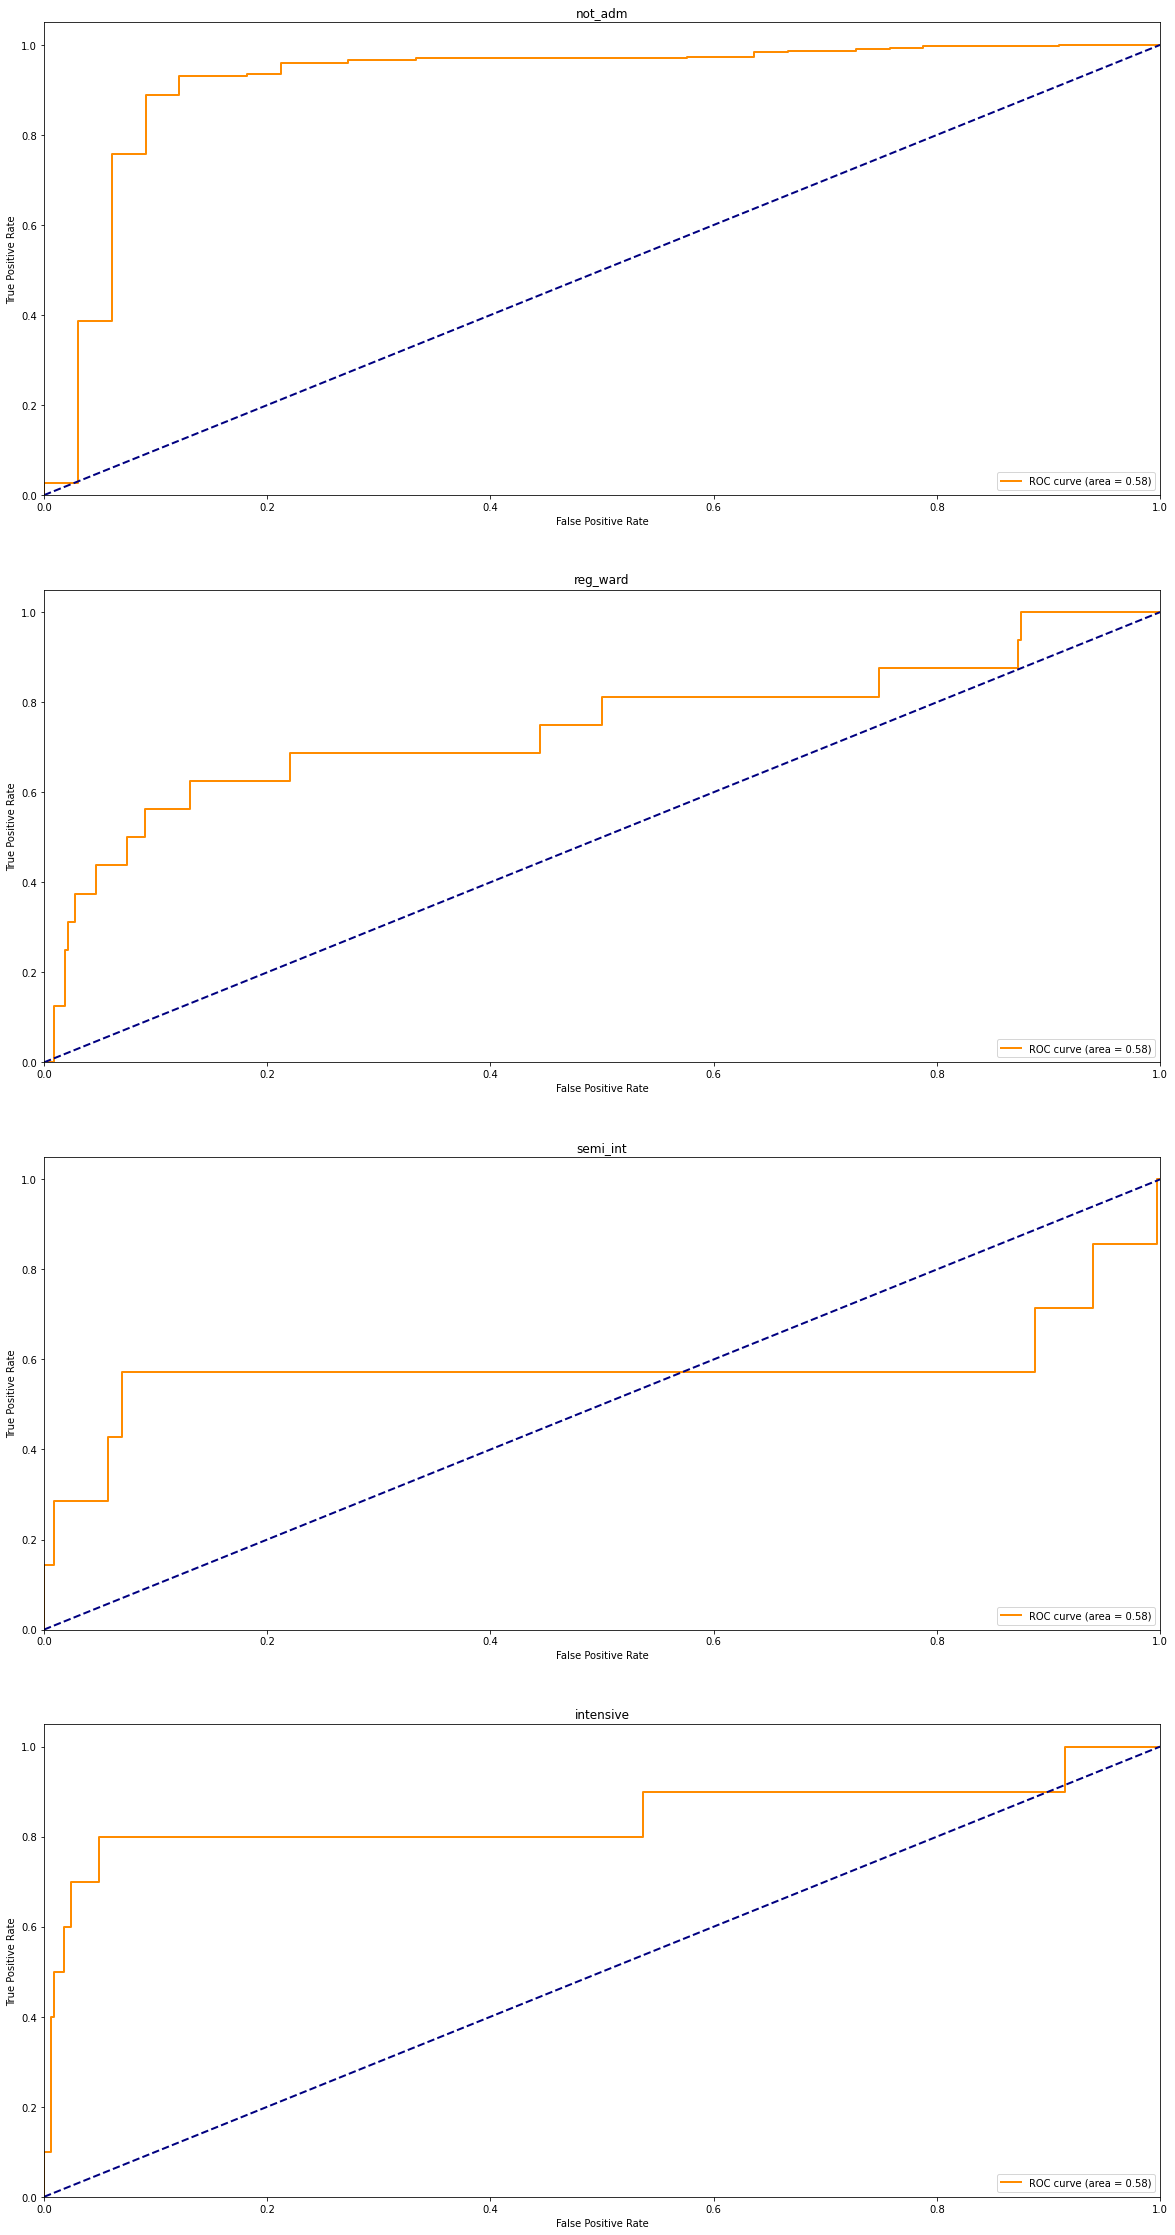

In [55]:
fig,ax = plt.subplots(len(label_list),figsize=(20,40))

for i in range(0,len(label_list)):
    ax[i].plot(fpr[i], tpr[i], color='darkorange',
            lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
    ax[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[i].set_xlim([0.0, 1.0])
    ax[i].set_ylim([0.0, 1.05])
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')
    ax[i].set_title(label_list[i])
    ax[i].legend(loc="lower right")
    
    print(label_list[i], classification_report(y_test[:,i],y_pred[:,i]), auc(fpr[i],tpr[i]))
    

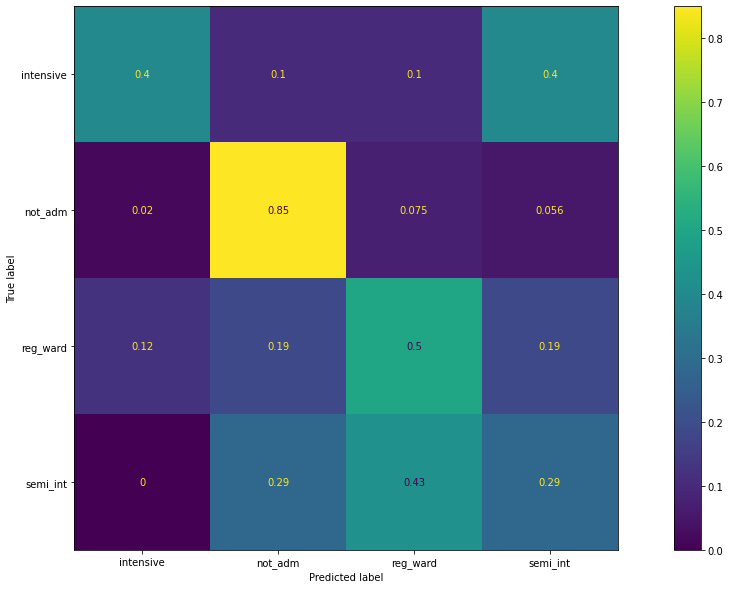

In [0]:
from sklearn.metrics import plot_confusion_matrix
class_labels = y_train.value_counts().index.to_list()
fig,ax = plt.subplots(figsize=(20,10))

cf_plot = plot_confusion_matrix(clf,X_test,y_test,ax=ax,normalize='true')



## K Nearest Neighbors

In [59]:
smote = SMOTE()

X = df.drop('adm_status',axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = df['adm_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.25, random_state=42)

X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [60]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()

clf.fit(X_train_resampled,y_train_resampled)

y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

   intensive       0.55      0.60      0.57        10
     not_adm       0.98      0.94      0.96       305
    reg_ward       0.37      0.44      0.40        16
    semi_int       0.08      0.14      0.10         7

    accuracy                           0.89       338
   macro avg       0.49      0.53      0.51       338
weighted avg       0.92      0.89      0.90       338



In [62]:
clf = KNeighborsClassifier()

params = {
    'n_neighbors': [i for i in range(10,20)],
    'weights':['uniform','distance'],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size':[i for i in range(5,40)],
    'p':[i for i in range(1,4)]
}

gs_kneighb_class = GridSearchCV(estimator=clf,param_grid=params,cv=5)
gs_kneighb_class.fit(X_train,y_train)

gs_kneighb_class.best_score_
gs_kneighb_class.best_params_

{'algorithm': 'auto',
 'leaf_size': 5,
 'n_neighbors': 10,
 'p': 1,
 'weights': 'distance'}

## Decision Tree

In [0]:
clf = DecisionTreeClassifier()

params = {
    'criterion': ['entropy','gini'],
    'splitter':['best', 'random'],
    'max_depth':[i for i in np.linspace(1, 32, 32, endpoint=True)],
    'min_samples_split':[i for i in np.linspace(0.1, 1.0, 10, endpoint=True)],
    'min_samples_leaf':[i for i in np.linspace(0.1, 0.5, 5, endpoint=True)]
}

gs_dec_tree = GridSearchCV(estimator=clf,param_grid=params,cv=5)
gs_dec_tree.fit(X_train,y_train)

gs_dec_tree.best_score_
gs_dec_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 1.0,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1,
 'splitter': 'best'}

In [0]:
gs_dec_tree.best_score_

0.9023703848217334

In [0]:
tree_dict = {'criterion': 'entropy',
 'max_depth': 1.0,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1,
 'splitter': 'best'}

tree_clf = DecisionTreeClassifier(criterion='entropy',
 max_depth=1.0,
 min_samples_leaf= 0.1,
 min_samples_split= 0.1,
 splitter= 'best')

tree_clf.fit(X_train_resampled,y_train_resampled)
y_score = tree_clf.predict(X_test)

class_report_1 = classification_report(y_test,y_score)

print(class_report_1)


              precision    recall  f1-score   support

   intensive       0.19      0.90      0.32        10
     not_adm       0.97      0.92      0.95       305
    reg_ward       0.00      0.00      0.00        16
    semi_int       0.00      0.00      0.00         7

    accuracy                           0.86       338
   macro avg       0.29      0.46      0.32       338
weighted avg       0.88      0.86      0.86       338



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest

In [0]:

clf = RandomForestClassifier()
clf.fit(X_train,y_train)
 
y_score = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_score)

print(class_report_1)

              precision    recall  f1-score   support

   intensive       1.00      0.40      0.57        10
     not_adm       0.93      1.00      0.96       305
    reg_ward       0.50      0.12      0.20        16
    semi_int       0.00      0.00      0.00         7

    accuracy                           0.92       338
   macro avg       0.61      0.38      0.43       338
weighted avg       0.89      0.92      0.89       338



## XGboost

In [0]:
import xgboost as xgb
clf = xgb.XGBClassifier( objective='multi:softmax', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10,scale_pos_weight=15)
clf.fit(X_train,y_train)

y_score = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_score)

print(class_report_1)

              precision    recall  f1-score   support

   intensive       1.00      0.40      0.57        10
     not_adm       0.93      1.00      0.96       305
    reg_ward       1.00      0.06      0.12        16
    semi_int       0.17      0.14      0.15         7

    accuracy                           0.92       338
   macro avg       0.77      0.40      0.45       338
weighted avg       0.92      0.92      0.89       338



## Support Vector Machines